In [2]:
!pip -V

pip 23.3.1 from /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/pip (python 3.10)


In [3]:
!pip list | grep clip

clip                      1.0


In [4]:
!pip list | grep opencv
!pip list | grep scikit-learn

opencv-python             4.10.0.84
scikit-learn              1.5.1


In [5]:
# !pip install git+https://github.com/mhamilton723/FeatUp.git
# !pip install pip install git+https://github.com/openai/CLIP.git

# .init

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path
workspace_dir = Path.cwd()
if not (workspace_dir / '.git').exists():
    workspace_dir = workspace_dir.parent


module_path = str(workspace_dir.resolve()) # os.path.abspath(os.path.join('..'))
print(f'workspace dir: {module_path}')

# Fixes a periodic issue with locating local packages.
if module_path not in sys.path:
    sys.path.append(module_path)

workspace dir: /root/feature-map-experiments


In [3]:
import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm
from featup.plotting import plot_feats, plot_lang_heatmaps

## Dino v2 upsampler

In [4]:
import matplotlib.pyplot as plt
from featup.util import pca, remove_axes
from pytorch_lightning import seed_everything

from fmc.plot_utils import plot_feats_pca, display_image_grid, display_image_grid_gs

In [5]:
from fmc.segmenter import init_upsampler, transform, mass_upsample, save_indexes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
upsampler = init_upsampler(device=device)


Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/h

## Patch utils

In [6]:
from fmc.patches_utils import extract_patch, extract_patches_numpy, extract_patches_pillow_matrix, extract_patches_pillow


# Image conf

In [7]:
# patch_size = int(224/2)
patch_size = 224

overlap = 0
# patch_size = int(256/2)
# overlap = int(26/2)

step = patch_size - overlap
output_overlap = int(256 * overlap / patch_size)

print(f'{patch_size=} {overlap=} {step=} {output_overlap=}')


patch_size=224 overlap=0 step=224 output_overlap=0


## Load images

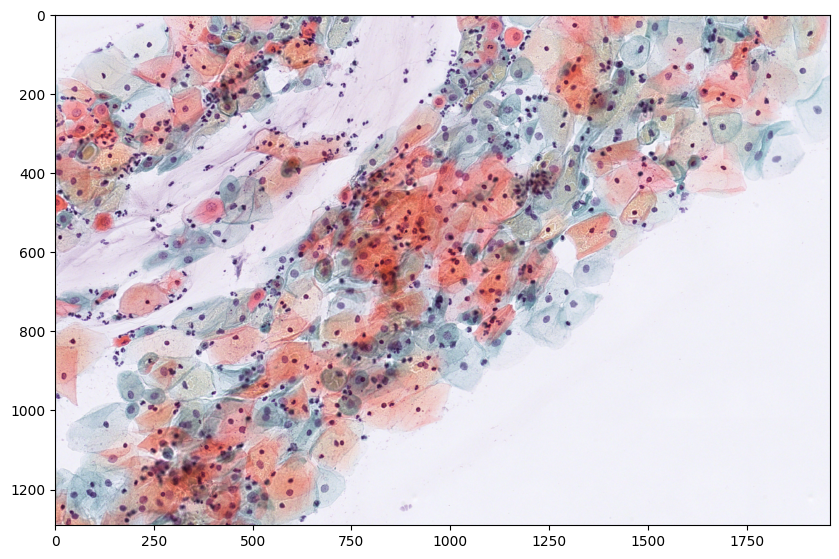

In [8]:
# image_path = '/root/feature-map-experiments/assets/c16-part1.png'
image_path = '/root/feature-map-experiments/assets/c17-part1.png'
# image_path = '/root/feature-map-experiments/assets/UT_cytopathology_213_239_roi_7333.jpeg'
# image_path = '../assets/DJI_1065.png'
# image_path = '/root/feature-map-experiments/assets/0297_Exposed Pipe.png'

image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [9]:
patches_mat = extract_patches_pillow_matrix(image, patch_size=(patch_size, patch_size), step=(step,step))
patches_mat.shape

(5, 8, 224, 224, 3)

# Draw Patches Grid

In [10]:
print(f'{patches_mat.shape[0:2]=}')

patches_mat_shape = patches_mat.shape[0:2]
flat_patches_mat = patches_mat.reshape(-1, *patches_mat.shape[2:])

patches_mat.shape[0:2]=(5, 8)


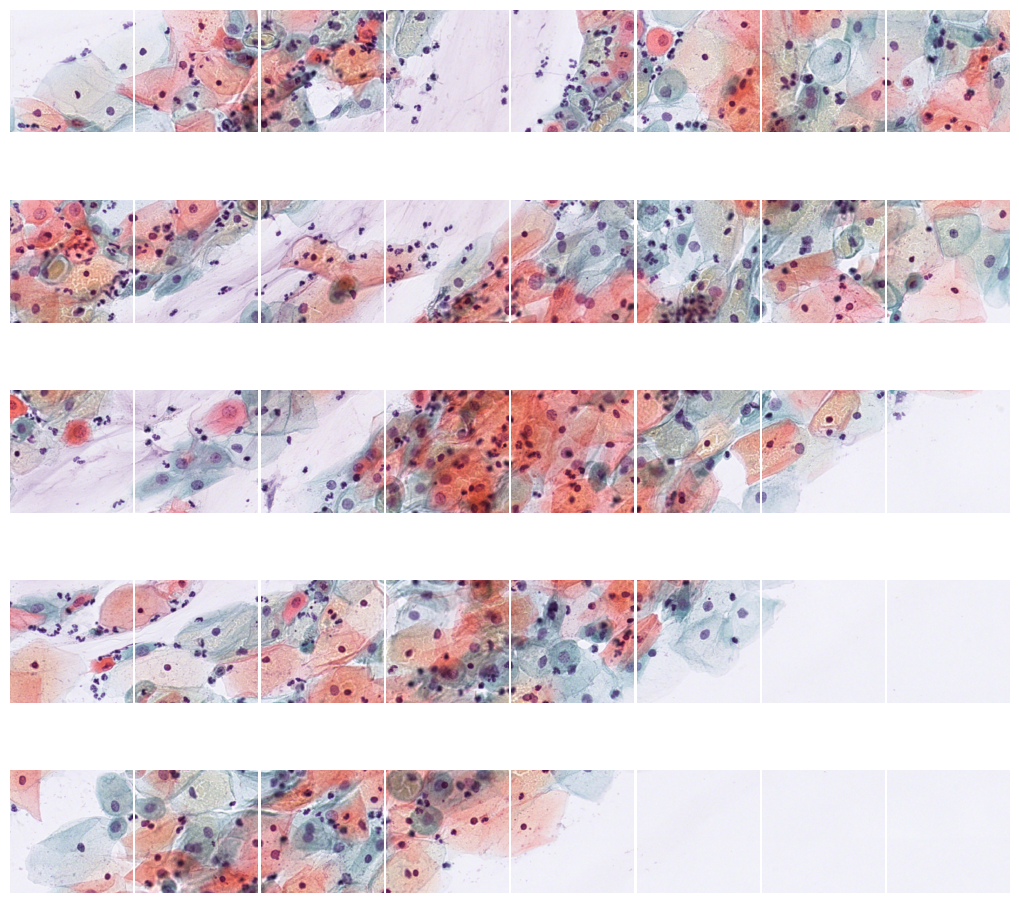

In [11]:
display_image_grid(flat_patches_mat, patches_mat_shape)

In [12]:
flat_patches_mat[0].shape

(224, 224, 3)

In [13]:
save_indexes(source_image_key=Path(image_path).stem,
    hr_feats=flat_patches_mat, patches_mat_shape=patches_mat_shape, 
    workspace_dir=workspace_dir, method_name='original', mode='RGB', patch_size=(patch_size,patch_size))

In [14]:
flat_patches_mat.shape

(40, 224, 224, 3)

In [15]:
import multiprocessing

multiprocessing.cpu_count()

80

# Calculate significant patch indexes

In [16]:
from fmc.image_utils import detect_blank_patch
threshold = 10.
significant_patch_indexes = []
for i, patch in enumerate(flat_patches_mat):
    mean, std_dev, is_blank = detect_blank_patch(patch, threshold=threshold)
    if is_blank:
        print(f'excluded {i}: {mean=} {std_dev=}')
    else:
        significant_patch_indexes.append(i)


excluded 23: mean=0.009466677295918366 std_dev=6.131622082939421
excluded 30: mean=0.00017936862244897957 std_dev=3.6200512666513496
excluded 31: mean=0.0013950892857142855 std_dev=3.2280456418661094
excluded 37: mean=0.001574457908163265 std_dev=3.211813519825414
excluded 38: mean=-0.0012356505102040815 std_dev=3.115329179498886
excluded 39: mean=0.0013950892857142855 std_dev=3.071512607679488


# Process using upsampler

## Just pre-experiments

In [17]:
# image_tensor = transform(Image.fromarray(flat_patches_mat[4])).unsqueeze(0).to(device)

In [18]:

# hr_feats = upsampler(image_tensor)
# lr_feats = upsampler.model(image_tensor)
# fit_pca = plot_feats_pca(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

In [19]:
# print(f'{hr_feats.shape=} {lr_feats.shape=}')

## Mass processing

In [20]:
lr_feats_list, hr_feats_list = mass_upsample(upsampler, flat_patches_mat, device=device)

image_tensors.shape=torch.Size([40, 3, 224, 224])


/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


lr_feats_list.shape=torch.Size([40, 384, 16, 16])  hr_feats_list.shape=torch.Size([40, 384, 256, 256])


In [21]:
# fit_pca = None
# unn_image_tensors = unnorm(image_tensors)
# for i in range(3):
#     fit_pca = plot_feats_pca(unn_image_tensors[i], lr_feats[i], hr_feats[i], fit_pca = fit_pca)

# Select meaningful patches

In [22]:
lr_feats_list.shape

torch.Size([40, 384, 16, 16])

In [23]:
s_lr_feats_list = lr_feats_list[significant_patch_indexes] 
s_hr_feats_list = hr_feats_list[significant_patch_indexes]

# Dimensionality reduction on image features

In [24]:
hr_feats_list[4].shape

torch.Size([384, 256, 256])

Seed set to 0


pca: x.shape=torch.Size([4456448, 384])
pca: x.shape=torch.Size([2631680, 384])
hr_feats_pca.shape=torch.Size([40, 3, 256, 256])


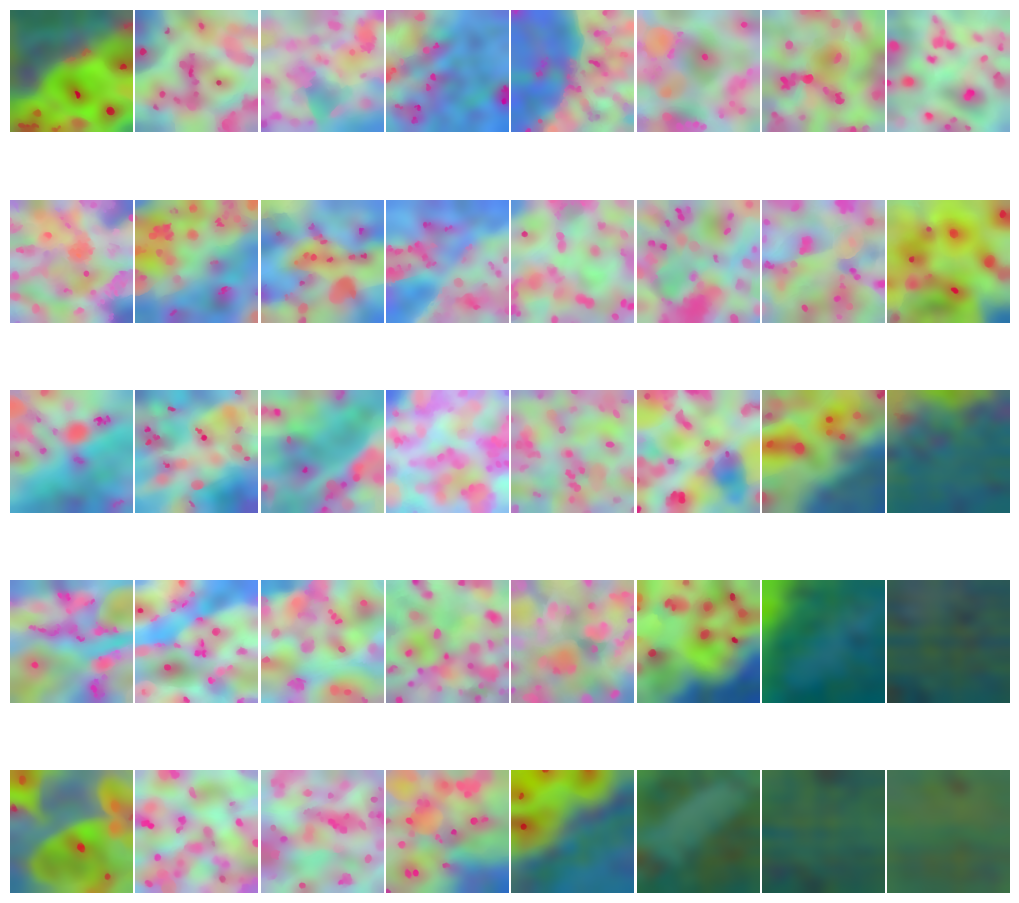

In [25]:
seed_everything(0)
fit_pca = None
use_meaning_strategy = 'significant'
if use_meaning_strategy == 'single_patch':
    _, fit_pca = pca([hr_feats_list[4].unsqueeze(0), lr_feats_list[4].unsqueeze(0)], fit_pca=fit_pca)
elif use_meaning_strategy == 'significant':
    _, fit_pca = pca([s_hr_feats_list, s_lr_feats_list], fit_pca=fit_pca)



[hr_feats_pca, lr_feats_pca], fit_pca = pca([hr_feats_list, lr_feats_list], fit_pca=fit_pca)
# [hr_feats_pca, _], fit_pca = pca([hr_feats_list, hr_feats_list], fit_pca=None)
print(f'{hr_feats_pca.shape=}')


hr_feats_pca_arr = [p.permute(1, 2, 0).detach().cpu() for p in hr_feats_pca]

display_image_grid(hr_feats_pca_arr, patches_mat_shape)

In [26]:
hr_feats_pca[0].shape

torch.Size([3, 256, 256])

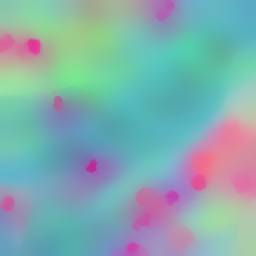

In [27]:
import torchvision.transforms as transforms
transforms.ToPILImage('RGB')(hr_feats_pca[18])

In [28]:

from fmc.patches_utils import assemble_image
# import importlib
# import fmc.patches_utils
# importlib.reload(fmc.patches_utils)


assembled_im = assemble_image(hr_feats_pca, patches_mat_shape)
assembled_im.save('assembled_feats.png')

### save pca feats as index

In [29]:
hr_feats_pca[0].shape

torch.Size([3, 256, 256])

In [30]:
save_indexes(source_image_key=Path(image_path).stem,
    hr_feats=hr_feats_pca, patches_mat_shape=patches_mat_shape, 
    workspace_dir=workspace_dir, method_name='pca', patch_size=(256,256))


In [31]:
import pickle

with open("pca_model.pkl", "wb") as f:
    pickle.dump(fit_pca, f)

In [32]:
fit_pca

In [33]:
len(hr_feats_pca_arr)

40

In [34]:
import numpy as np
hr_feats_pca_flat = np.stack(hr_feats_pca_arr)
hr_feats_pca_flat.shape

(40, 256, 256, 3)

In [35]:
hr_feats_mat = hr_feats_pca_flat.reshape(
    patches_mat_shape[0], patches_mat_shape[1], *hr_feats_pca_flat.shape[1:])

hr_feats_mat.shape

(5, 8, 256, 256, 3)

## UMAP on image features

In [36]:
hr_feats_list.detach().cpu().numpy().shape

(40, 384, 256, 256)

In [49]:
import numpy as np
from fmc.segmenter import umap_fl


fit_umap = None
use_meaning_strategy = 'significant'
if use_meaning_strategy == 'meaning_center':
    _, fit_umap = umap_fl([lr_feats_list[4].unsqueeze(0), hr_feats_list[4].unsqueeze(0)], fit_umap=fit_umap)
elif use_meaning_strategy == 'significant':
    _, fit_umap = umap_fl([s_hr_feats_list, s_lr_feats_list], fit_umap=fit_umap)

print(f'{fit_umap=}')
[lr_feats_umap, hr_feats_umap], fit_umap = umap_fl([lr_feats_list, hr_feats_list], fit_umap=fit_umap)
# [hr_feats_pca, _], fit_pca = pca([hr_feats_list, hr_feats_list], fit_pca=None)

# ax[2].imshow(hr_feats_pca[0].permute(1, 2, 0).detach().cpu())
hr_feats_umap_arr = [p.permute(1, 2, 0).detach().cpu() for p in hr_feats_umap]

display_image_grid(hr_feats_umap_arr, patches_mat_shape)

umap fit: x.shape=torch.Size([4456448, 384])
Create new umap
UMAP(n_components=3, n_jobs=70, verbose=True)
Thu Sep 19 00:14:00 2024 Construct fuzzy simplicial set
Thu Sep 19 00:14:06 2024 Finding Nearest Neighbors
Thu Sep 19 00:14:07 2024 Building RP forest with 64 trees
Thu Sep 19 00:21:04 2024 NN descent for 22 iterations
	 1  /  22
	 2  /  22
	Stopping threshold met -- exiting after 2 iterations
Thu Sep 19 00:33:44 2024 Finished Nearest Neighbor Search
Thu Sep 19 00:34:21 2024 Construct embedding


In [38]:

with open("umap_model.pkl", "wb") as f:
    pickle.dump(fit_umap, f)

In [39]:
hr_feats_umap_flat = np.stack(hr_feats_umap_arr)
hr_feats_umap_flat.shape

(40, 256, 256, 3)

In [40]:
save_indexes(source_image_key=Path(image_path).stem,
    hr_feats=hr_feats_umap, patches_mat_shape=patches_mat_shape, 
    workspace_dir=workspace_dir, method_name='umap', patch_size=(256,256))


### CuML umap

In [258]:
import torch.nn.functional as F
from cuml.manifold import UMAP as cumlUMAP

def cuml_umap_fl(image_feats_list, dim=3, fit_umap=None, max_samples=None):
    device = image_feats_list[0].device

    def flatten(tensor, target_size=None):
        if target_size is not None and fit_umap is None:
            tensor = F.interpolate(
                tensor, (target_size, target_size), mode="bilinear")
        B, C, H, W = tensor.shape
        return tensor.permute(1, 0, 2, 3).reshape(C, B * H * W).permute(1, 0).detach().cpu()

    if len(image_feats_list) > 1 and fit_umap is None:
        target_size = image_feats_list[0].shape[2]
    else:
        target_size = None

    flattened_feats = []
    for feats in image_feats_list:
        flattened_feats.append(flatten(feats, target_size))
    x = torch.cat(flattened_feats, dim=0)

    # Subsample the data if max_samples is set and the number of samples exceeds max_samples
    if max_samples is not None and x.shape[0] > max_samples:
        indices = torch.randperm(x.shape[0])[:max_samples]
        x = x[indices]

    x = x.detach().cpu().numpy()
    print(f'umap fit: {x.shape=}')
    if fit_umap is None:
        print('Create new umap')
        
        fit_umap = cumlUMAP(n_components=dim, 
                            #  random_state=42, 
                            #  n_jobs=n_jobs, 
                             verbose=True,
                            #  unique=True
                             ).fit(x)

    reduced_feats = []
    for feats in image_feats_list:
        x_red = fit_umap.transform(
            flatten(feats).numpy()
            )
        if isinstance(x_red, np.ndarray):
            x_red = torch.from_numpy(x_red)
        x_red -= x_red.min(dim=0, keepdim=True).values
        x_red /= x_red.max(dim=0, keepdim=True).values
        B, C, H, W = feats.shape
        reduced_feats.append(
            x_red.reshape(B, H, W, dim).permute(0, 3, 1, 2).to(device)
            )

    return reduced_feats, fit_umap

from cuml.common.device_selection import using_device_type

with using_device_type('GPU'):
    _, fit_cuml_umap = cuml_umap_fl([s_hr_feats_list, s_lr_feats_list], fit_umap=None, max_samples=256*256*1)
    print(f'{fit_cuml_umap=}')
    [lr_feats_umap, hr_feats_umap], fit_umap = cuml_umap_fl([lr_feats_list, hr_feats_list], fit_umap=fit_cuml_umap)
    # [hr_feats_pca, _], fit_pca = pca([hr_feats_list, hr_feats_list], fit_pca=None)

    # ax[2].imshow(hr_feats_pca[0].permute(1, 2, 0).detach().cpu())
    hr_feats_umap_arr = [p.permute(1, 2, 0).detach().cpu() for p in hr_feats_umap]

    display_image_grid(hr_feats_umap_arr, patches_mat_shape)


umap fit: x.shape=(65536, 384)
Create new umap


MemoryError: std::bad_alloc: CUDA error at: /tmp/pip-build-env-fkfud_57/normal/lib/python3.10/site-packages/librmm/include/rmm/mr/device/cuda_memory_resource.hpp:60: cudaErrorIllegalAddress an illegal memory access was encountered

# Clustering features values

In [36]:
from cuml.common.device_selection import set_global_device_type, get_global_device_type

initial_device_type = get_global_device_type()
print('default execution device:', initial_device_type)

default execution device: DeviceType.device


## Clustering using pca & umap features

In [37]:
from fmc.segmenter import kmeans_color_quantization, kmeans_predict, kmeans_process

In [242]:
import cuml
from cuml.cluster.hdbscan import HDBSCAN
from cuml.common.device_selection import using_device_type

# def hdbscan_color_quantization(hr_feats_flat):
all_feats_values = hr_feats_pca_flat.reshape(-1, 3)
print(f'{all_feats_values.shape=}')
with using_device_type('GPU'):
    clusterer = HDBSCAN(
        min_samples=80, 
        min_cluster_size=120,
        gen_min_span_tree=True,
        
        prediction_data=True, 
        verbose=True,
        )
    labels = clusterer.fit_predict(all_feats_values)
    # cuml.cluster.hdbscan.all_points_membership_vectors(clusterer)



all_feats_values.shape=(2621440, 3)


In [210]:

with open("hdbscan.pkl", "wb") as f:
    pickle.dump(clusterer, f)

In [251]:
print(f'unique labels: {len(np.unique(labels))} {np.max(labels)=} {np.min(labels)=} {labels.shape=}')

unique labels: 21 np.max(labels)=19 np.min(labels)=-1 labels.shape=(2621440,)


In [245]:
hr_umap_shape = hr_feats_pca_flat.shape
hr_umap_shape

(40, 256, 256, 3)

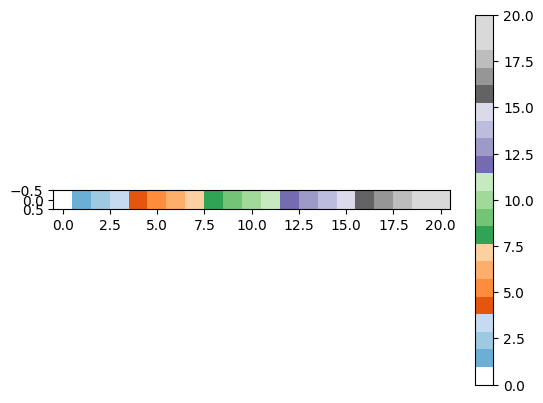

In [246]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors

cmap = matplotlib.colormaps['tab20c']

pp_size = len(np.unique(labels))
# cc_palette = cmap(range(pp_size))

cc_palette = cmap(np.linspace(0, 1, pp_size))   
cc_palette[0] = [0., 0., 0., 0.]
# cc_palette

new_cmap = mcolors.ListedColormap(cc_palette)

# Используем новую палитру
plt.imshow([range(pp_size)], cmap=new_cmap)
plt.colorbar()
plt.show()

In [247]:
cc_labels = labels+1
np.min(cc_labels)

0

In [248]:
cc1_labels = cc_palette[cc_labels]
cc1_labels.shape

(2621440, 4)

In [249]:
all_segmented_images = cc1_labels.reshape(hr_umap_shape[0], hr_umap_shape[1], hr_umap_shape[2], 4)
all_segmented_images.shape

(40, 256, 256, 4)

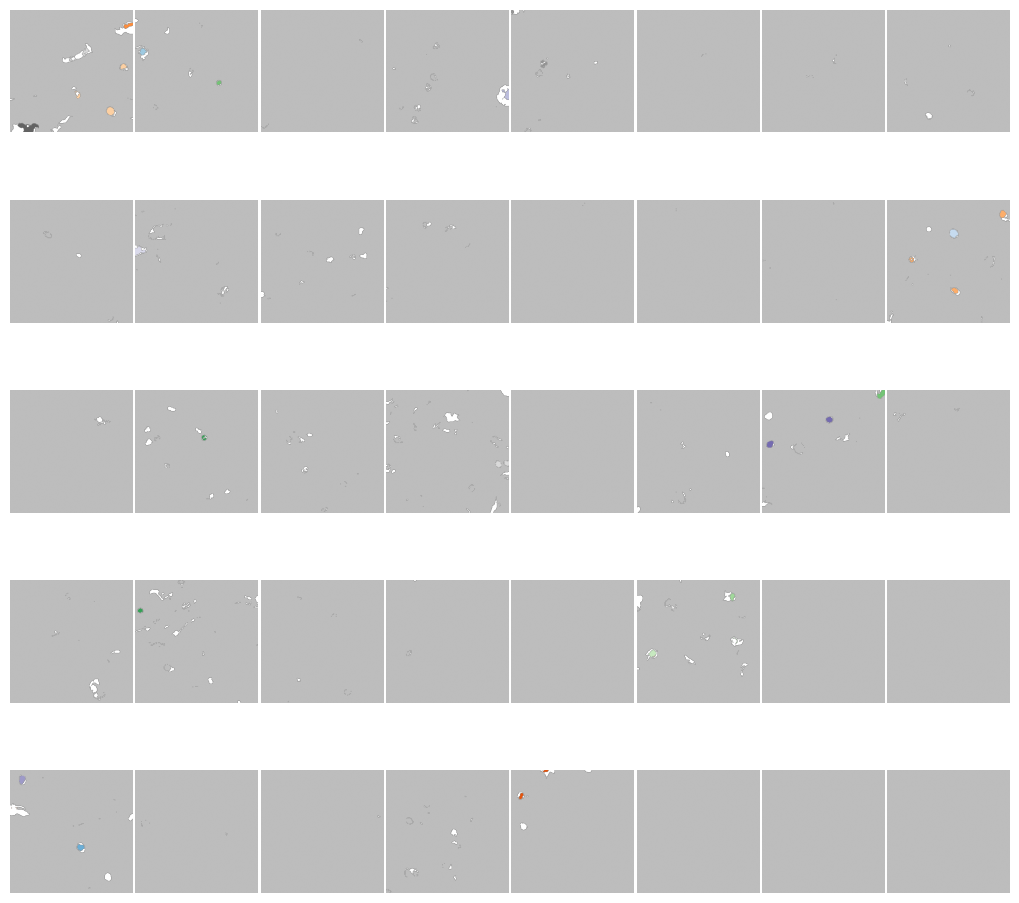

In [250]:
display_image_grid(all_segmented_images, patches_mat_shape)

In [110]:
save_indexes(source_image_key=Path(image_path).stem,
    hr_feats=all_segmented_images, patches_mat_shape=patches_mat_shape, 
    workspace_dir=workspace_dir, method_name='hdbscan', mode='RGBA', patch_size=(256,256))


In [50]:
# clusterer.minimum_spanning_tree_.plot()
# clusterer.single_linkage_tree_.plot()

In [63]:
clusterer.minimum_spanning_tree_


In [52]:
all_segmented_feats[24]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

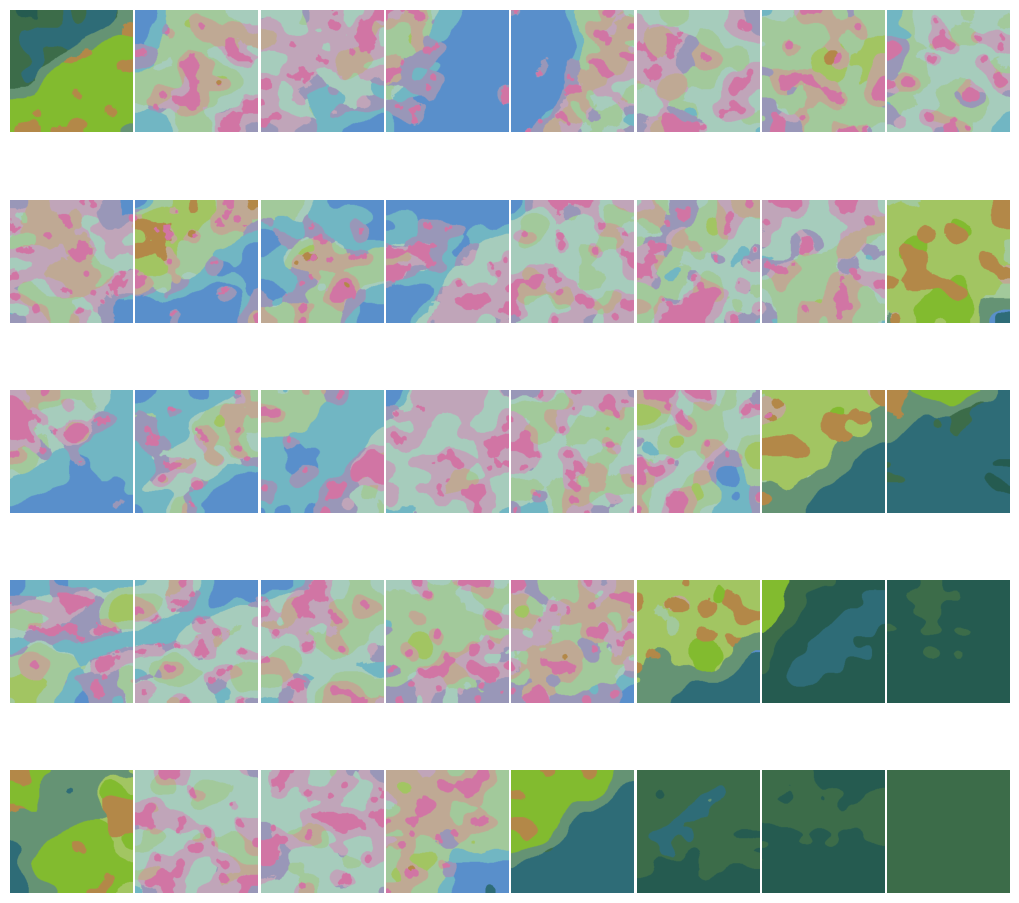

In [109]:
pca_all_segmented_feats,_ = kmeans_process(hr_feats_pca_flat)
display_image_grid(pca_all_segmented_feats, patches_mat_shape)

In [112]:
save_indexes(source_image_key=Path(image_path).stem,
    hr_feats=pca_all_segmented_feats, patches_mat_shape=patches_mat_shape, 
    workspace_dir=workspace_dir, method_name='kmeans-pca', mode='RGB')

In [110]:
umap_all_segmented_feats, _ = kmeans_process(hr_feats_umap_flat, k=26)
display_image_grid(umap_all_segmented_feats, patches_mat_shape)

NameError: name 'hr_feats_umap_flat' is not defined

In [115]:
save_indexes(source_image_key=Path(image_path).stem,
    hr_feats=umap_all_segmented_feats, patches_mat_shape=patches_mat_shape, 
    workspace_dir=workspace_dir, method_name='kmeans-umap', mode='RGB', patch_size=(256,256))

In [55]:
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

NameError: name 'kmeans' is not defined

In [76]:
kmeans.cluster_centers_

array([[0.75085306, 0.6662748 , 0.58142287],
       [0.23571426, 0.42480785, 0.2899846 ],
       [0.4431545 , 0.7151244 , 0.76672846],
       [0.7541004 , 0.649161  , 0.72811985],
       [0.35272792, 0.56409824, 0.7991824 ],
       [0.39709574, 0.5797986 , 0.45592642],
       [0.7040717 , 0.5346096 , 0.28469488],
       [0.6520089 , 0.8028735 , 0.7395061 ],
       [0.5134304 , 0.7333519 , 0.18512681],
       [0.8232318 , 0.46061665, 0.6469236 ],
       [0.63658535, 0.77482665, 0.387246  ],
       [0.6038528 , 0.59321135, 0.723876  ],
       [0.18306059, 0.42422658, 0.4691007 ],
       [0.14654258, 0.35879937, 0.3145164 ],
       [0.6374234 , 0.78969073, 0.60829014]], dtype=float32)

In [77]:
colors = kmeans.cluster_centers_.tolist()

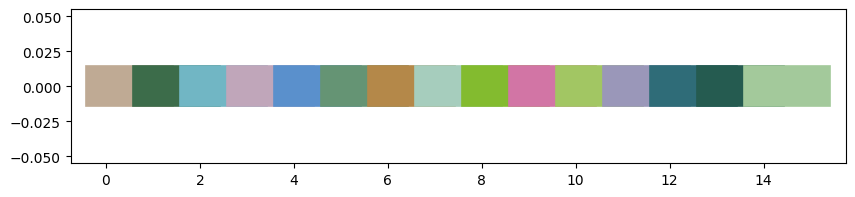

In [78]:
plt.figure(figsize=(10, 2))
# colors = colors[12:15]
# Рисуем каждый цвет в своем квадрате
for i in range(len(colors)):
    plt.plot([i, i+1], [0, 0], color=colors[i], linewidth=30)

plt.show()

## Visualize

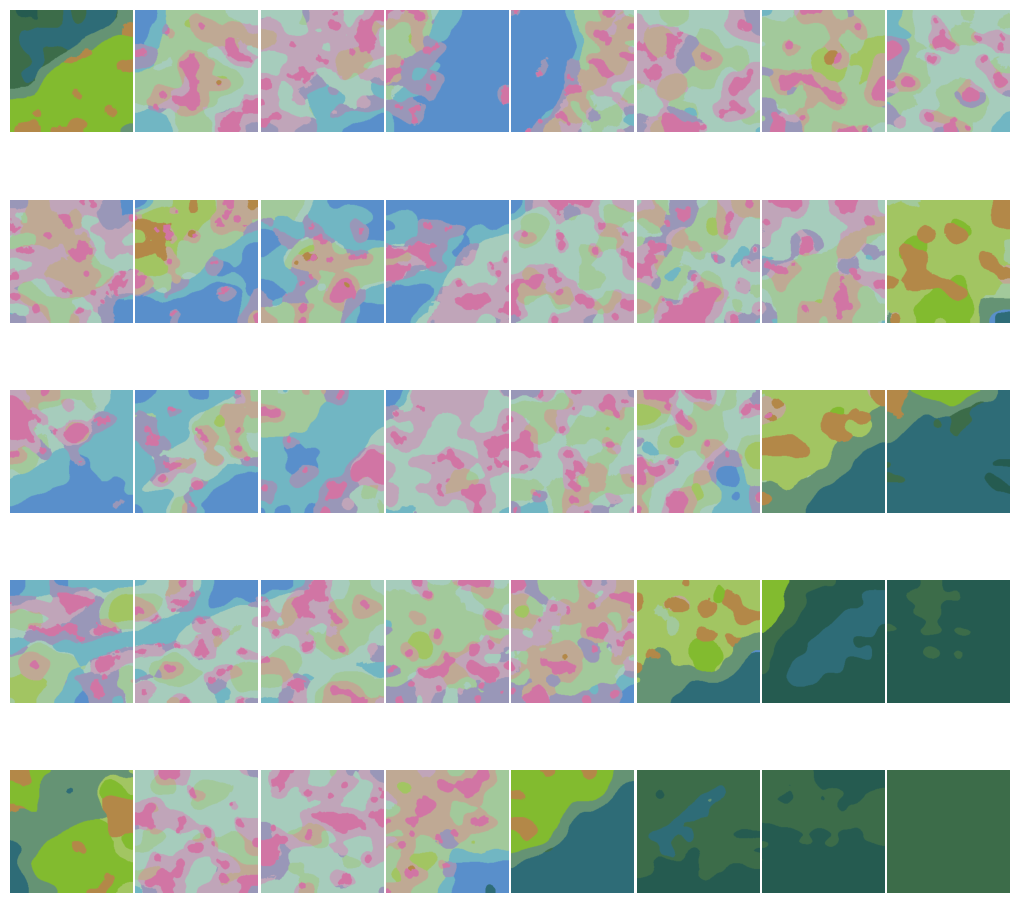

In [79]:
display_image_grid(all_segmented_feats, patches_mat_shape)

In [111]:
colors2 = kmeans.cluster_centers_.tolist()
for i in range(len(colors2)-1):
    colors2[i] = [0.,0.,0.]
colors2[14] = colors[9]
colors2[7] = colors[3]
plt.figure(figsize=(10, 2))
for i in range(len(colors2)):
    plt.plot([i, i+1], [0, 0], color=colors2[i], linewidth=30)

plt.show()

colors2 = np.array(colors2)

NameError: name 'kmeans' is not defined

In [112]:
all_segmented_feats = []
for hr_feats in hr_feats_pca_flat:
    segmented_feats = kmeans_predict(kmeans, hr_feats, palette=colors2)
    all_segmented_feats.append(segmented_feats)

display_image_grid(all_segmented_feats, patches_mat_shape)

NameError: name 'kmeans' is not defined

## Clustering using HDBSCAN

In [54]:
from sklearn.cluster import DBSCAN, HDBSCAN

def hdbscan_color_quantization(pixel_values):
    # Параметры для KMeans
    clusterer = HDBSCAN(min_cluster_size=1000, min_samples=30, n_jobs=60)

    # Применение KMeans
    clusterer.fit(pixel_values)

    # Преобразование центров обратно в uint8
    centers = clusterer.cluster_centers_

    return clusterer, centers


def hdbscan_predict(clusterer, hr_feats, palette = None):
    shape = hr_feats.shape
    feats = hr_feats.reshape((-1, shape[-1]))
    # print(f'{shape=} {feats.shape=}')

    labels = clusterer.predict(feats)
    # print(f'{labels.shape=}')
    centers = clusterer.cluster_centers_
    if palette is not None:
        segmented_image = palette[labels.flatten()]
    else:
        segmented_image = centers[labels.flatten()]
    # print(f'{segmented_image.shape=}')
    segmented_image = segmented_image.reshape((shape[0],shape[1],3))
    return segmented_image

In [55]:

hdbscan_clusterer, centers = hdbscan_color_quantization(all_feats_values, k)

all_segmented_feats = []
for hr_feats in hr_feats_pca_flat:
    segmented_feats = hdbscan_predict(hdbscan_clusterer, hr_feats)
    all_segmented_feats.append(segmented_feats)

## Clustering using original values

In [33]:
hr_feats_list.shape

torch.Size([9, 384, 256, 256])

In [34]:
hr_feats_list_flat = hr_feats_list.permute(0,2,3,1).numpy()
hr_feats_list_flat.shape

(9, 256, 256, 384)

In [35]:
# Combining all 'pixels' into one large dataset


all_feats_values_orig = hr_feats_list_flat.reshape(-1, 384)
all_feats_values_orig.shape

(589824, 384)

In [36]:
# Применение K-means кластеризации ко всему набору данных
k = 20
kmeans2, centers2 = kmeans_color_quantization(all_feats_values_orig, k)

/tmp/ipykernel_28000/3186361605.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


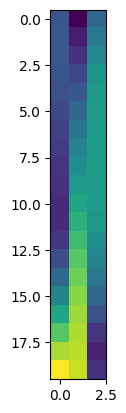

In [37]:
# Создаем colormap
cmap = plt.cm.get_cmap('viridis')

# Получаем палитру размера k
palette = cmap(np.linspace(0, 1, k))
palette = np.delete(palette, 3, axis=1)

plt.imshow(palette)
plt.show()

In [38]:
centers2.shape

(20, 384)

In [39]:
hr_feats_list_flat[0].shape

(256, 256, 384)

In [40]:
all_segmented_feats = []
for hr_feats in hr_feats_list_flat:
    segmented_feats = kmeans_predict(kmeans2, hr_feats, palette=palette)
    all_segmented_feats.append(segmented_feats)

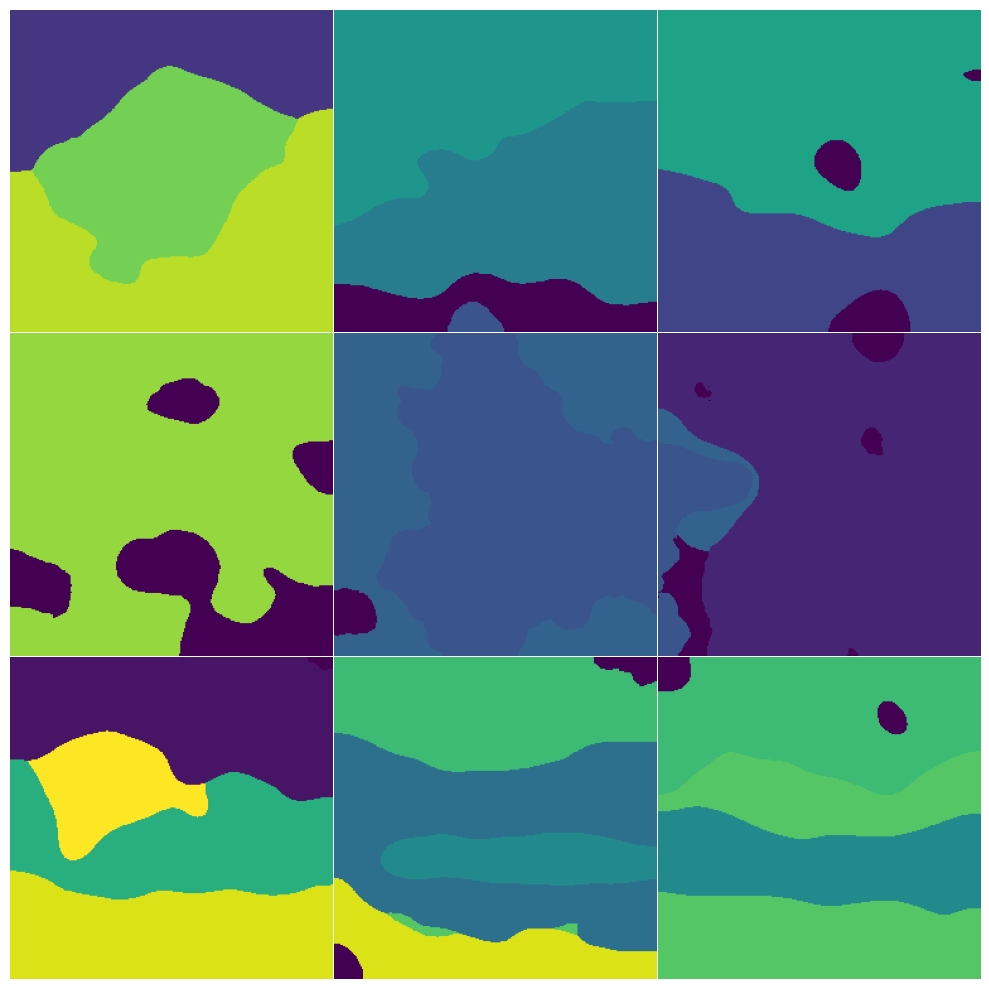

In [41]:
display_image_grid(all_segmented_feats, patches_mat_shape)

# Merge and blend patches

## series 1

In [35]:
def linear_blend_masks(masks, patch_size, overlap):
    num_patches_h, num_patches_w = masks.shape[0], masks.shape[1]
    full_height = num_patches_h * patch_size - (num_patches_h - 1) * overlap
    full_width = num_patches_w * patch_size - (num_patches_w - 1) * overlap
    full_mask = np.zeros((full_height, full_width, masks.shape[-1]), dtype=np.float32)
    weight_mask = np.zeros_like(full_mask)

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y_start = i * (patch_size - overlap)
            x_start = j * (patch_size - overlap)
            y_end = y_start + patch_size
            x_end = x_start + patch_size

            patch_mask = masks[i, j]
            if i > 0:
                patch_mask[:overlap, :] *= np.linspace(0, 1, overlap*3).reshape(-1, 1, 3)
            if j > 0:
                patch_mask[:, :overlap] *= np.linspace(0, 1, overlap*3).reshape(-1,3)
            if i < num_patches_h - 1:
                patch_mask[-overlap:, :] *= np.linspace(1, 0, overlap*3).reshape(-1, 1, 3)
            if j < num_patches_w - 1:
                patch_mask[:, -overlap:] *= np.linspace(1, 0, overlap*3).reshape(-1,3)

            print(
                f'{full_mask[y_start:y_end, x_start:x_end].shape=} {patch_mask.shape=}')
            full_mask[y_start:y_end, x_start:x_end] += patch_mask
            weight_mask[y_start:y_end, x_start:x_end] += 1

    full_mask /= np.maximum(weight_mask, 1)
    return full_mask


def gaussian_blend_masks(masks, patch_size, overlap):
    num_patches_h, num_patches_w = masks.shape[0], masks.shape[1]
    full_height = num_patches_h * patch_size - (num_patches_h - 1) * overlap
    full_width = num_patches_w * patch_size - (num_patches_w - 1) * overlap
    full_mask = np.zeros((full_height, full_width), dtype=np.float32)
    weight_mask = np.zeros_like(full_mask)

    gaussian_weights = np.outer(cv2.getGaussianKernel(overlap * 2 + 1, 0.3 * ((overlap * 2 + 1) - 1) + 0.8),
                                cv2.getGaussianKernel(overlap * 2 + 1, 0.3 * ((overlap * 2 + 1) - 1) + 0.8))

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y_start = i * (patch_size - overlap)
            x_start = j * (patch_size - overlap)
            y_end = y_start + patch_size
            x_end = x_start + patch_size

            patch_mask = masks[i, j]
            if i > 0:
                patch_mask[:overlap, :] *= gaussian_weights[overlap:,
                                                            overlap:].reshape(-1, 1)
            if j > 0:
                patch_mask[:, :overlap] *= gaussian_weights[overlap:, overlap:]
            if i < num_patches_h - 1:
                patch_mask[-overlap:, :] *= gaussian_weights[:overlap,
                                                             overlap:].reshape(-1, 1)
            if j < num_patches_w - 1:
                patch_mask[:, -overlap:] *= gaussian_weights[overlap:, :overlap]

            full_mask[y_start:y_end, x_start:x_end] += patch_mask
            weight_mask[y_start:y_end, x_start:x_end] += 1

    full_mask /= np.maximum(weight_mask, 1)
    return full_mask

## series 2

In [36]:
def blend_patches(patches, patch_size, overlap):
    """
    Blend a matrix of overlapping patches into one large image.

    Parameters:
    patches (numpy array): A 4D array of shape (num_patches_y, num_patches_x, patch_size[0], patch_size[1])
    patch_size (tuple): The size of each patch (height, width)
    overlap (int): The number of overlapping pixels between patches

    Returns:
    numpy array: The blended large image
    """
    num_patches_y, num_patches_x = patches.shape[:2]
    patch_height, patch_width = patch_size

    # Calculate the size of the final image
    final_height = num_patches_y * patch_height - (num_patches_y - 1) * overlap
    final_width = num_patches_x * patch_width - (num_patches_x - 1) * overlap

    # Initialize the final image
    final_image = np.zeros(
        (final_height, final_width, patches.shape[2]), dtype=patches.dtype)

    # Initialize the weight mask
    weight_mask = np.zeros((patch_height, patch_width), dtype=np.float32)
    weight_mask[:overlap, :] = np.linspace(0, 1, overlap)
    weight_mask[-overlap:, :] = np.linspace(1, 0, overlap)
    weight_mask[:, :overlap] = np.linspace(0, 1, overlap)[np.newaxis, :]
    weight_mask[:, -overlap:] = np.linspace(1, 0, overlap)[np.newaxis, :]
    weight_mask[overlap:-overlap, overlap:-overlap] = 1

    # Blend the patches into the final image
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = patches[i, j]
            y_start = i * (patch_height - overlap)
            y_end = y_start + patch_height
            x_start = j * (patch_width - overlap)
            x_end = x_start + patch_width

            # Apply the weight mask to the patch
            weighted_patch = patch * weight_mask[..., np.newaxis]

            # Blend the patch into the final image
            final_image[y_start:y_end, x_start:x_end] += weighted_patch

    return final_image

## Series 3

In [37]:
from scipy.interpolate import interp2d


def blend_patches_interpolate(patches, patch_size, overlap):
    """
    Blend a matrix of overlapping patches into one large image using interpolation.

    Parameters:
    patches (numpy array): A 4D array of shape (num_patches_y, num_patches_x, patch_size[0], patch_size[1], channels)
    patch_size (tuple): The size of each patch (height, width)
    overlap (int): The number of overlapping pixels between patches

    Returns:
    numpy array: The blended large image
    """
    num_patches_y, num_patches_x = patches.shape[:2]
    patch_height, patch_width = patch_size
    channels = patches.shape[4]

    # Calculate the size of the final image
    final_height = num_patches_y * patch_height - (num_patches_y - 1) * overlap
    final_width = num_patches_x * patch_width - (num_patches_x - 1) * overlap

    # Initialize the final image
    final_image = np.zeros(
        (final_height, final_width, channels), dtype=patches.dtype)

    # Create a grid for interpolation
    x = np.linspace(0, patch_width - 1, patch_width)
    y = np.linspace(0, patch_height - 1, patch_height)
    xx, yy = np.meshgrid(x, y)

    # Blend the patches into the final image using interpolation
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = patches[i, j]
            y_start = i * (patch_height - overlap)
            y_end = y_start + patch_height
            x_start = j * (patch_width - overlap)
            x_end = x_start + patch_width

            # Create a weight mask for interpolation
            weight_mask = np.ones((patch_height, patch_width))
            if i > 0:
                weight_mask[:overlap,
                            :] *= np.linspace(0, 1, overlap)[:, np.newaxis]
            if i < num_patches_y - 1:
                weight_mask[-overlap:,
                            :] *= np.linspace(1, 0, overlap)[:, np.newaxis]
            if j > 0:
                weight_mask[:,
                            :overlap] *= np.linspace(0, 1, overlap)[np.newaxis, :]
            if j < num_patches_x - 1:
                weight_mask[:, -
                            overlap:] *= np.linspace(1, 0, overlap)[np.newaxis, :]

            # Apply the weight mask to the patch
            weighted_patch = patch * weight_mask[..., np.newaxis]

            # Interpolate the patch
            for c in range(channels):
                interpolator = interp2d(
                    xx, yy, weighted_patch[..., c], kind='linear')
                final_image[y_start:y_end, x_start:x_end,
                            c] += interpolator(x, y)

    return final_image

## Series 4

In [75]:
import numpy as np
# from skimage.util import view_as_windows


def blend_patches_g(patches, patch_size, overlap, blend_func=np.mean):
  """Blends overlapping patches into a single image.

  Args:
    patches: A numpy array of shape (num_patches, patch_size, patch_size, channels).
    patch_size: The size of each patch.
    overlap: The overlap between adjacent patches.
    blend_func: The blending function to use (default: np.mean).

  Returns:
    The blended image as a numpy array.
  """

  cols, rows, _, _, channels = patches.shape
  patch_step = patch_size - overlap

  # Calculate output image dimensions
  output_size = (rows * patch_step + overlap)

  # Create empty output image
  output_image = np.zeros(
      (output_size, output_size, channels), dtype=patches.dtype)

  # Iterate through patches
  for i in range(cols):
    for j in range(rows):
      patch = patches[i, j]
      start_x = i * patch_step
      end_x = start_x + patch_size
      start_y = j * patch_step
      end_y = start_y + patch_size

      # Calculate overlap region
      overlap_x = min(end_x, output_size) - max(start_x, 0)
      overlap_y = min(end_y, output_size) - max(start_y, 0)

      # Apply blending function
      output_image[start_x:end_x, start_y:end_y] = blend_func(
          (output_image[start_x:end_x, start_y:end_y],
           patch[:overlap_x, :overlap_y]),
          axis=0
      )

  return output_image

In [72]:
from scipy.interpolate import RectBivariateSpline


def smooth_blend_patches_intp(patches, patch_size, overlap):
  """Smoothly blends overlapping patches into a single image using 2D interpolation.

  Args:
    patches: A numpy array of shape (num_patches, patch_size, patch_size, channels).
    patch_size: The size of each patch.
    overlap: The overlap between adjacent patches.

  Returns:
    The blended image as a numpy array.
  """

  # num_patches, _, _, channels = patches.shape
  cols, rows, _, _, channels = patches.shape
  num_patches = cols * rows
  patch_step = patch_size - overlap

  # Calculate output image dimensions
  output_size = (num_patches * patch_step + overlap)

  # Create empty output image
  output_image = np.zeros(
      (output_size, output_size, channels), dtype=patches.dtype)

  # Iterate through patches
  for i in range(cols):
    for j in range(rows):
      patch = patches[i, j]
      start_x = i * patch_step
      end_x = start_x + patch_size
      start_y = j * patch_step
      end_y = start_y + patch_size

      # Calculate overlap region
      overlap_x = min(end_x, output_size) - max(start_x, 0)
      overlap_y = min(end_y, output_size) - max(start_y, 0)

      # Create interpolation function
      interp_func = RectBivariateSpline(
          np.arange(patch_size), np.arange(patch_size), patch)

      # Generate coordinates for interpolation
      x = np.arange(start_x, min(end_x, output_size))
      y = np.arange(start_y, min(end_y, output_size))
      X, Y = np.meshgrid(x, y)

      # Interpolate patch values onto output image
      output_image[start_x:end_x, start_y:end_y] += interp_func(X, Y)

  return output_image

## Blend

In [76]:
print(f'{hr_feats_mat.shape=}')
# m = linear_blend_masks(hr_feats_mat, 256, output_overlap)

m = blend_patches_g(hr_feats_mat,  256, output_overlap)
# m = smooth_blend_patches_intp(hr_feats_mat, 256, output_overlap)

hr_feats_mat.shape=(5, 7, 256, 256, 3)


In [40]:
m.shape

(1024, 1408, 3)

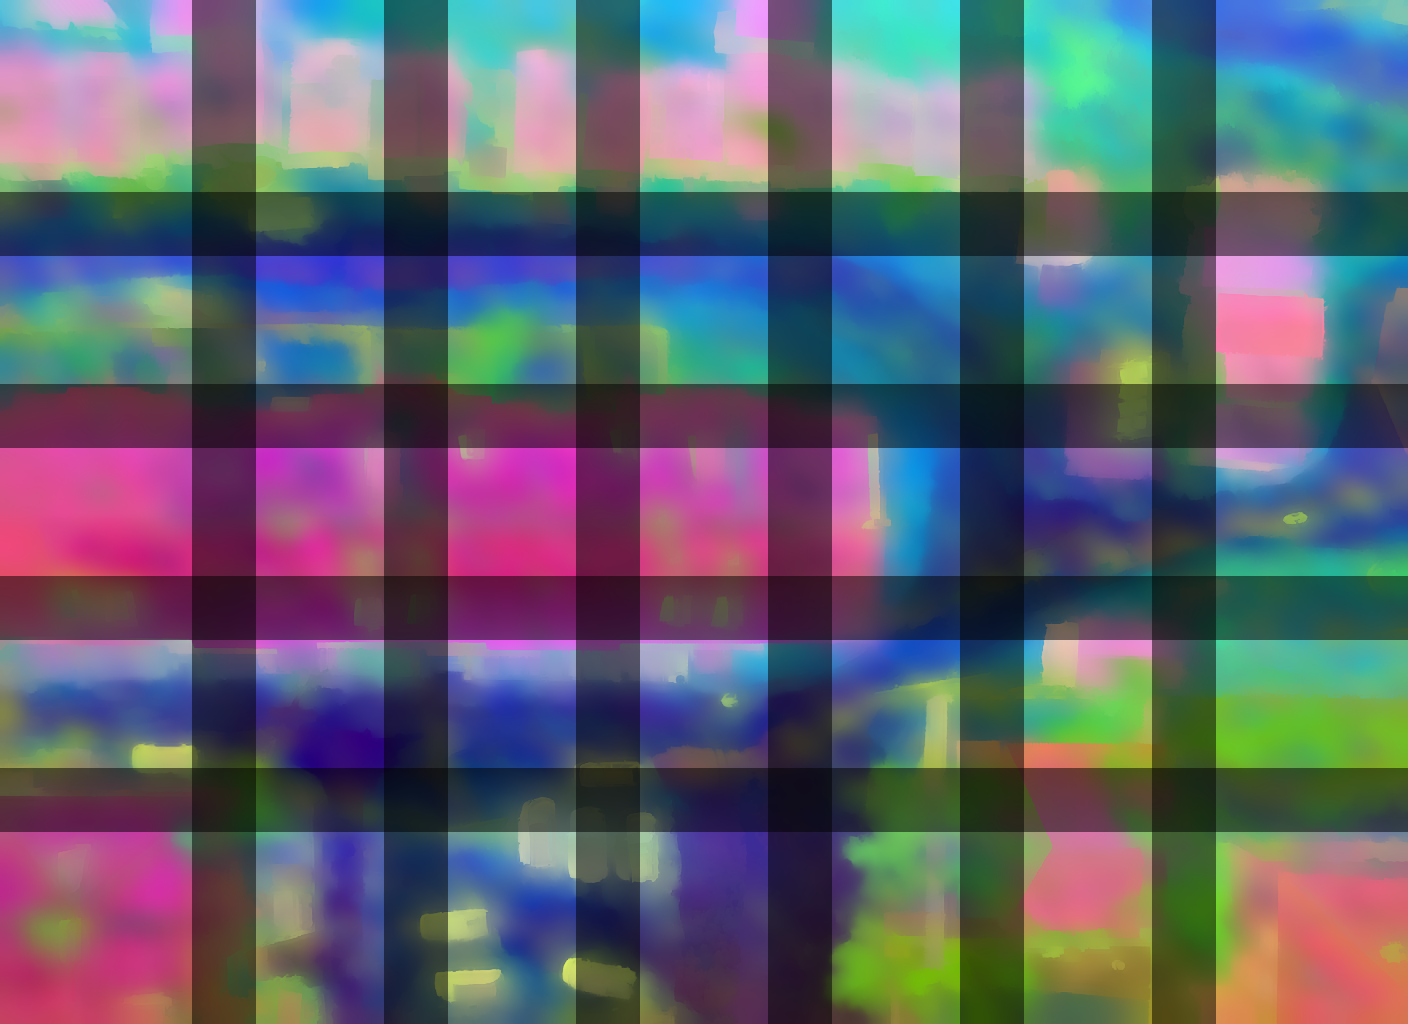

In [41]:
import matplotlib.pyplot as plt


rim = Image.fromarray((m*255).astype(np.uint8))

# fig, ax = plt.subplots(figsize=(10, 10))  
# ax.imshow(m)
# ax.set_axis_off()
# # plt.colorbar()
# plt.show()
rim